In [2]:
!pip install torch torchvision efficientnet_pytorch matplotlib scikit-learn pandas opencv-python
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b2097a482f20fb9802e99fdfb07495096d087787fb2cdd6f300955a465317303
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-kdejphji
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-kdejphji
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit fd4b5c863fbfc06b23d2d396413e08831c2c2ecf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=41820 sha256=2a16b0679837b1bc39083ff8139e084c7771827fc1b5db638a3b0b0955fa2f43
  Stored in 

In [3]:
import os

base_dir = '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data'

train_dir = f'{base_dir}/train'
validation_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

print('Train:', os.listdir(train_dir))
print('Validation:', os.listdir(validation_dir))
print('Test:', os.listdir(test_dir))


Train: ['2', '0', '3', '1', '4']
Validation: ['2', '0', '3', '1', '4']
Test: ['2', '0', '3', '1', '4']


In [4]:
import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))


GPU available: True
GPU device: Tesla P100-PCIE-16GB


In [5]:
from torchvision import datasets, transforms
import torch

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
}


In [6]:
batch_size = 64

train_dataset = datasets.ImageFolder(train_dir, transform=image_transforms['train'])
val_dataset = datasets.ImageFolder(validation_dir, transform=image_transforms['val_test'])
test_dataset = datasets.ImageFolder(test_dir, transform=image_transforms['val_test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print('Classes:', class_names)


Classes: ['0', '1', '2', '3', '4']


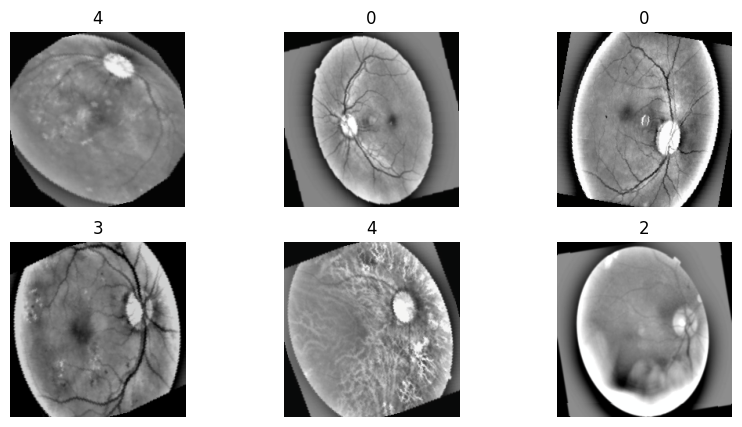

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

images, labels = next(iter(train_loader))
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    imshow(images[i], class_names[labels[i]])
plt.show()


In [8]:
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet
import torch.nn as nn

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 34.1MB/s]


Loaded pretrained weights for efficientnet-b3


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [10]:
from tqdm.notebook import tqdm  # For Kaggle notebooks

epochs = 10
best_acc = 0.0
patience, trigger_times = 5, 0

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss, val_correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f} | Accuracy: {val_correct}/{len(val_loader.dataset)} = {val_correct/len(val_loader.dataset):.4f}")

    scheduler.step(epoch_val_loss)

    # Early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'efficientnet_b3_retinopathy.pt')
        print("✅ Model improved and saved!")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ No improvement ({trigger_times}/{patience})")
        if trigger_times >= patience:
            print("❗ Early stopping triggered!")
            break


Epoch 1/10


Training Epoch 1:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 1 Training Loss: 1.0328


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.8800 | Accuracy: 6307/9940 = 0.6345
✅ Model improved and saved!
Epoch 2/10


Training Epoch 2:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.7950


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.6905 | Accuracy: 7045/9940 = 0.7088
✅ Model improved and saved!
Epoch 3/10


Training Epoch 3:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.6563


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.6354 | Accuracy: 7257/9940 = 0.7301
✅ Model improved and saved!
Epoch 4/10


Training Epoch 4:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.5529


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.5341 | Accuracy: 7688/9940 = 0.7734
✅ Model improved and saved!
Epoch 5/10


Training Epoch 5:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.4730


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.5302 | Accuracy: 7767/9940 = 0.7814
✅ Model improved and saved!
Epoch 6/10


Training Epoch 6:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.4047


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.4717 | Accuracy: 8008/9940 = 0.8056
✅ Model improved and saved!
Epoch 7/10


Training Epoch 7:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.3404


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.4660 | Accuracy: 8107/9940 = 0.8156
✅ Model improved and saved!
Epoch 8/10


Training Epoch 8:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.2849


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.4537 | Accuracy: 8224/9940 = 0.8274
✅ Model improved and saved!
Epoch 9/10


Training Epoch 9:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.2453


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.4213 | Accuracy: 8404/9940 = 0.8455
✅ Model improved and saved!
Epoch 10/10


Training Epoch 10:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.2095


Validation:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.3904 | Accuracy: 8552/9940 = 0.8604
✅ Model improved and saved!


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
y_true, y_pred = [], []

model.load_state_dict(torch.load('efficientnet_b3_retinopathy.pt'))
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


<ipython-input-13-65a3c621c1d6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_b3_retinopathy.pt'))


              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1000
           1       0.80      0.87      0.84       971
           2       0.78      0.77      0.77      1000
           3       0.98      0.99      0.99      1000
           4       0.99      1.00      0.99      1000

    accuracy                           0.86      4971
   macro avg       0.86      0.86      0.86      4971
weighted avg       0.86      0.86      0.86      4971



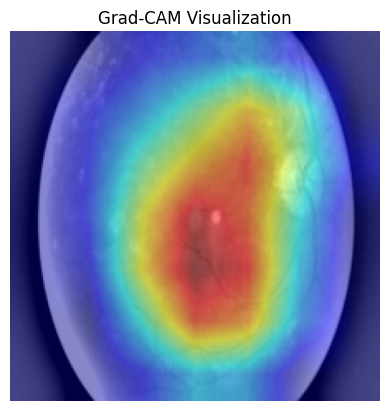

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

# Select the target convolutional layer for EfficientNet-B3
target_layer = model._conv_head

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Get one batch of images
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)

# Forward pass to obtain predictions
model.eval()
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Select one image from batch
img_tensor = inputs[0].unsqueeze(0)

# Generate GradCAM
grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0, :]

# De-normalize image for visualization
img = inputs[0].cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean  # De-normalize
img = np.clip(img, 0, 1)

# Overlay GradCAM on image
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# Display the GradCAM result
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()
